In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
import os
import random
import sklearn
import pandas as pd
import h5py
import torch
import copy
from google.colab import drive


SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
sklearn.utils.check_random_state(SEED)

drive.mount('/content/drive')


Mounted at /content/drive


# Regularization

Regularization is a central concept in statistical modeling that helps prevent overfitting and improve generalization. The core idea of regularization is that it adds a penalty term to the loss function which encourages the model to learn simpler patterns.

In this notebook, we will explore how regularization works in the context of SVMs and linear regression. We'll do so in three sections:
1. As warmup, we'll reimplement an SVM classifier as we did last week
2. Exploring the effects of regularization on SVM classifiers for simple, artificial data
3. Exploring the effects of regularization on SVM classifiers on real, neural data

We'll be using the same UniversalProcedure class from lecture 8. If you closely, you will see some small changes to this class. Don't worry about them for now -- we'll revisit them later.

In [2]:
# Universal Procedure class from lecture 8
class UniversalProcedure:
    """A class to implement the universal procedure for model training and evaluation."""

    def __init__(
        self, cross_validator, evaluation_metrics={}, loss_func=None, optimizer=None
    ):

        self.cross_validator = cross_validator
        self.evaluation_metrics = evaluation_metrics

        if loss_func is None:
            self.loss_func = nn.MSELoss()
        else:
            self.loss_func = loss_func

        if optimizer is None:
            self.optimizer = optim.Adam
        else:
            self.optimizer = optimizer

    def train(
        self,
        model,  # The instantiated but untrained PyTorch model
        X_train,  # The training data input
        y_train,  # The training labels (the desired output)
        train_epochs,  # How many epochs to train for
        lr,  # The learning rate to use
        reg_type, # We'll talk about this later
        reg_lambda # We'll talk about this later
    ):

        # Set up optimizer and loss function from self
        optimizer = self.optimizer(model.parameters(), lr=lr)
        loss_fn = self.loss_func

        # Track losses during training
        losses = []

        # Training loop
        for epoch in range(train_epochs):
            # Forward pass
            y_pred = model(X_train)  # Gets the prediction

            # Compute loss
            loss = loss_fn(y_pred, y_train)  # Runs the loss function
            losses.append(loss.item())  # Appends the loss for later tracking purposes

            # Backward pass and optimize
            optimizer.zero_grad()  # To make sure gradients don't accumulate
            loss.backward()  # This actually calls the derivation calculation
            optimizer.step()  # This actually applies the update

        return losses

    def evaluate(self, model, x, y, train_epochs=500, lr=0.01, reg_type="L2", reg_lambda=1):

        # Initialize results dictionary
        results = {}
        for name in self.evaluation_metrics.keys():
            results[f"splits_{name}_test"] = []
            results[f"splits_{name}_train"] = []

        # Get default params from model
        original_state_dict = copy.deepcopy(
            model.state_dict()
        )  # Save initial parameters

        # State_dict list to store trained model parameters
        state_dicts = []

        # Perform cross-validation
        for train_idx, test_idx in self.cross_validator.split(x):
            # Split data
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Reset model parameters
            model.load_state_dict(original_state_dict)

            # Fit model
            self.train(model, x_train, y_train, train_epochs, lr, reg_type, reg_lambda)

            # Get predictions
            with torch.no_grad():
                y_test_pred = model.predict(x_test)
                y_train_pred = model.predict(x_train)

            # Calculate metrics
            for name, metric_fn in self.evaluation_metrics.items():
                results[f"splits_{name}_test"].append(metric_fn(y_test, y_test_pred))
                results[f"splits_{name}_train"].append(metric_fn(y_train, y_train_pred))
            state_dicts.append(copy.deepcopy(model.state_dict()))

        # Average metrics across folds
        for name in self.evaluation_metrics.keys():
            results[f"{name}_test_mean"] = np.mean(results[f"splits_{name}_test"])
            results[f"{name}_test_std"] = np.std(results[f"splits_{name}_test"])
            results[f"{name}_train_mean"] = np.mean(results[f"splits_{name}_train"])
            results[f"{name}_train_std"] = np.std(results[f"splits_{name}_train"])

        return results, state_dicts

## I. Implementing an SVM classifier with regularization

In the first part of this notebook we're going to work with some simple synthetic data. Like the previous lesson, we are going to focus on the problem of classification.

Let's take a look at the data we'll be working with:

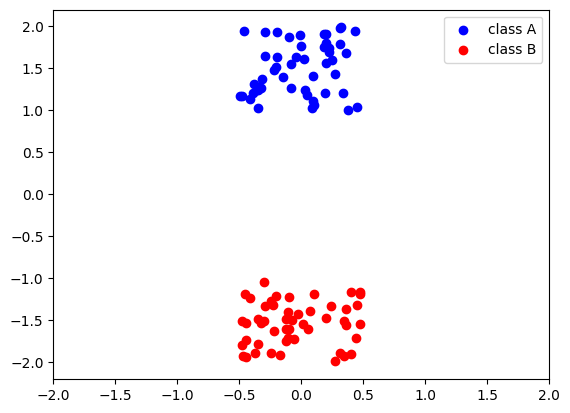

In [3]:
def generate_block_data(K):

    # Set random seed for reproducibility
    torch.manual_seed(SEED)

    xp = torch.tensor([-0.5, 1])
    dataplus = xp + torch.rand(K, 2)

    xm = torch.tensor([-0.5, -2.0])
    dataminus = xm + torch.rand(K, 2)

    data = torch.cat([dataplus, dataminus], dim=0)
    labels = torch.cat([torch.ones(K), -1 * torch.ones(K)])

    return data, labels


def rotate_block_data(data, ang):

    rotation_matrix = torch.tensor([
        [torch.cos(torch.tensor(ang)), torch.sin(torch.tensor(ang))],
        [-torch.sin(torch.tensor(ang)), torch.cos(torch.tensor(ang))]
    ])

    data = torch.matmul(data, rotation_matrix)

    return data


data, labels = generate_block_data(50)
data = rotate_block_data(data, 0)

dp = data[labels == 1]
dm = data[labels == -1]
plt.scatter(dp[:, 0], dp[:, -1], color='blue', label='class A')
plt.scatter(dm[:, 0], dm[:, -1], color='red', label='class B')
plt.xlim(-2, 2)
plt.ylim(-2.2, 2.2)
plt.legend()


As a warmup exercise, let's reimplement a binary SVM classifier and hinge loss function. This implementation is exactly the same as what we did in the previous notebook, but try and see if you can do it without looking back at your past work!

In [ ]:
class BinaryLinearSVM(nn.Module):
    """
    Binary linear SVM classifier.
    """

    def __init__(self, input_dim):
        """
        Initialize the SVM model.

        Args:
            input_dim: Dimensionality of input features
        """
        super(BinaryLinearSVM, self).__init__()

        # ---- YOUR CODE HERE ----
        # Initialize a linear layer (weights and bias) with nn.Linear
        self.linear = nn.Linear(input_dim, 1)
        # ----------------------

    def forward(self, x):
        """
        Forward pass to compute SVM scores.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            SVM scores of shape (batch_size,)
        """

        # ---- YOUR CODE HERE ----
        # Compute and return the raw scores
        # use .squeeze(1) after applying the linear layer to remove extra dimension
        return self.linear(x).squeeze(1)
        # ----------------------

    def predict(self, x):
        """
        Predict class labels.

        Args:
            x: features of shape (batch_size, input_dim)

        Returns:
            Predicted class labels (-1 or 1) of shape (batch_size,)
        """

        # ---- YOUR CODE HERE ----
        # apply forward, then...
        # HINT: use torch.where to convert all scores <= 0 to torch.tensor(-1.0), and otherwise to torch.tensor(1.0)
        # see documentation for torch.where: https://pytorch.org/docs/stable/generated/torch.where.html
        return torch.where(self.forward(x) <= 0, torch.tensor(-1.0), torch.tensor(1.0))
        # ----------------------

In [ ]:
class HingeLoss(nn.Module):
    """
    Hinge loss for binary SVM.
    """

    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, predictions, targets):
        """
        Compute hinge loss.

        Args:
            predictions: Raw SVM scores
            targets: True labels (-1 or 1)

        Returns:
            Mean hinge loss
        """

        # ---- YOUR CODE HERE ----
        # Calculate margin term: 1 - y * f(x)
        margins = 1 - predictions * targets

        # Apply max(0, margin) for each sample
        losses = torch.clamp(margins, min=0)

        # Return mean loss
        mean_loss = losses.mean()
        # ----------------------

        return mean_loss

We also need an evaluation metric for our SVM classifier. We'll use classification accuracy, which is the proportion of correctly classified samples. We provided this metric to you last week, but let's implement it here as well for practice.

Complete the code for the binary classification metric below. The formula for calculating accuracy is:

$Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{1}{n}\sum_{i=1}^{n} \mathbb{1}(predictions_i = y_i)$

where $\mathbb{1}$ is the indicator function that equals 1 when the condition inside the parentheses is true (prediction matches the actual label) and 0 otherwise. Note that in your implementation you will want to first binarize the predictions and labels to 0 and 1, before computing the accuracy. You can binarize a function x using `x = (x > 0).float()`.



In [ ]:
def classification_accuracy(y, y_pred):
    """Calculate accuracy for both binary and multi-class cases"""
    if y_pred.dim() == 1:

        # ---- YOUR CODE HERE ----
        # Binary classification case

        # Binarize predictions
        predictions = (y_pred > 0).float()

        # Binarize labels
        y = (y > 0).float()

        # Compute and return accuracy
        accuracy = (predictions == y).float().mean()
        return accuracy
        # ----------------------

    else:
        # Multi-class classification case
        predictions = torch.argmax(y_pred, dim=1)
        return (predictions == y).float().mean()

Now let's put together a wrapper function that uses our UniversalProcedure class, SVM classifer class, hinge loss class and classification accuracy function to train the SVM classifier on our data:

In [ ]:
def train_svm(data, labels, n_splits, test_size, train_epochs, lr, reg_type="L2", reg_lambda=1):

    # Initialize the SVM model
    input_dim = data.shape[1]
    svm_model = BinaryLinearSVM(input_dim)

    # Create cross-validation splitter
    cv_splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=SEED)

    # Create UniversalProcedure with hinge loss
    hinge_loss = HingeLoss()
    procedure = UniversalProcedure(cross_validator=cv_splitter, loss_func=hinge_loss, evaluation_metrics={"accuracy": classification_accuracy})

    # Train and evaluate
    svm_results, svm_state_dicts = procedure.evaluate(
        model=svm_model, x=data, y=labels, train_epochs=train_epochs, lr=lr, reg_type=reg_type, reg_lambda=reg_lambda
    )

    return svm_results, svm_state_dicts

svm_results, svm_state_dicts = train_svm(data, labels, n_splits=5, test_size=0.2, train_epochs=1000, lr=0.01)
for metric, value in svm_results.items():
    if "test_mean" in metric:
        print(f"{metric}: {value:.4f}")

accuracy_test_mean: 1.0000


And finally let's visualize the decision boundary of the trained model:

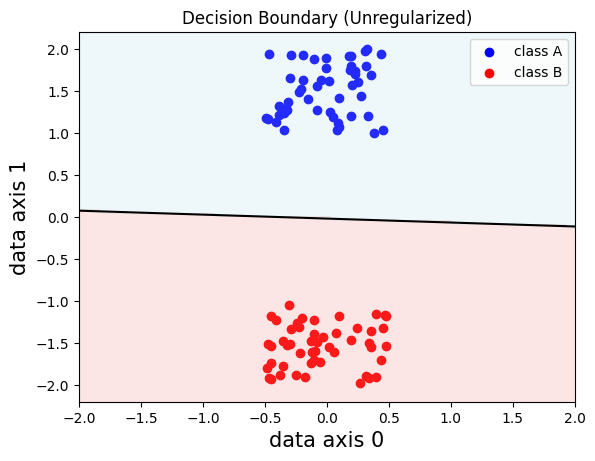

In [ ]:
svm_model = BinaryLinearSVM(data.shape[1])
svm_model.load_state_dict(svm_state_dicts[-1])

def plot_hyperplane(data, labels, model, title):

    dp = data[labels == 1]
    dm = data[labels == -1]
    plt.scatter(dp[:, 0], dp[:, -1], color='blue', label='class A')
    plt.scatter(dm[:, 0], dm[:, -1], color='red', label='class B')
    plt.legend()
    plt.xlim(-2, 2)
    plt.ylim(-2.2, 2.2)

    w0 = model.linear.weight[0, 0].item()
    w1 = model.linear.weight[0, 1].item()
    intr = model.linear.bias[0].item()
    m = -w0 / w1
    b = -intr / w1
    line = lambda x: m*x + b

    # Create a mesh grid for coloring the background
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Determine which side of the hyperplane each point is on
    Z = (xx * w0 + yy * w1 + intr) > 0

    # Color the background based on the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.2, colors=['lightcoral', 'lightblue'])

    # Plot the decision boundary
    line0 = line(-2)
    line1 = line(2)
    plt.plot([-2, 2], [line0, line1], color='k')
    plt.xlabel('data axis 0', fontsize=15)
    plt.ylabel('data axis 1', fontsize=15)
    plt.title(title)

plot_hyperplane(data, labels, svm_model, 'Decision Boundary (Unregularized)')

Nice! The decision boundary looks pretty reasonable given the data that we generated.

But what happens if we add just the tiniest bit of noise to the data?

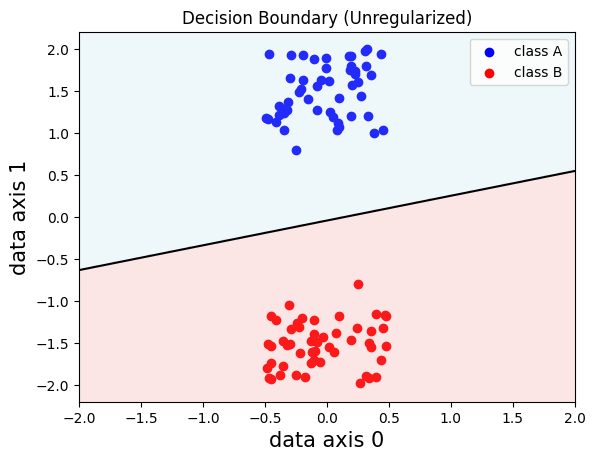

In [ ]:
data, labels = generate_block_data(50)
data = rotate_block_data(data, 0)

noisy_point_1, new_label_1 = torch.tensor([-0.25, 0.8]).unsqueeze(0), torch.tensor([1])
noisy_point_2, new_label_2 = torch.tensor([0.25, -0.8]).unsqueeze(0), torch.tensor([-1])

data = torch.cat([data, noisy_point_1, noisy_point_2], dim=0)
labels = torch.cat([labels, new_label_1, new_label_2], dim=0)

svm_results, svm_state_dicts = train_svm(data, labels, n_splits=5, test_size=0.2, train_epochs=1000, lr=0.01)

svm_model = BinaryLinearSVM(data.shape[1])
svm_model.load_state_dict(svm_state_dicts[-1])

plot_hyperplane(data, labels, svm_model, 'Decision Boundary (Unregularized)')

That's quite a dramatic shift in the decision boundary, even though we only added two points (that totally conform with the original boundary!).

Do you think it makes sense to adjust the decision boundary so much given just two new points? How might we prevent this from happening?

Answer: add regularization!

## II. Regularizing an SVM classifier for a toy dataset

#### L2 Regularization

First let's try implementing L2 regularization. L2 regularization adds a penalty term to the loss function that is proportional to the square of the magnitude of the weight vector:

$L_{reg} = λ * ||w||^2 = λ * Σ(w_i^2)$

where:
- λ is the regularization strength (hyperparameter)
- w is the weight vector
- ||w||^2 is the squared L2 norm of the weight vector

Let's implement a function that computes the L2 regularization term below. Note that are also including the function definition for L1 regularization below, but we'll implement that later. Note that in all code blocks and markdown cells, we'll be referring to λ as `reg_lambda` in order to avoid confusion with the `lambda` keyword in Python.


In [ ]:
def l2_regularization_term(model):

    # ---- YOUR CODE HERE ----
    # Hint: you can access model weights with model.linear.weight
    reg_loss = torch.sum(model.linear.weight ** 2)
    # ----------------------

    return reg_loss

def l1_regularization_term(model):
    raise NotImplementedError


Now that we have a function to compute the regularization term, we can modify the UniversalProcedure class to use it. Below is a new class definition for UniversalProcedure. It is exactly the same as before, except we have added a new _compute_regularization() function that computes the regularization term.

This rewritten class is almost ready to use, but it is missing one important piece: in the training loop, it does not yet update the loss function with the regularization term! Finish the new implementation by adding that functionality below. Specifically, you'll want to add the regularization term scaled by an input parameter reg_lambda to the regular loss function.

In [ ]:
class UniversalProcedure:
    """A class to implement the universal procedure for model training and evaluation."""

    def __init__(
        self, cross_validator, evaluation_metrics={}, loss_func=None, optimizer=None
    ):

        self.cross_validator = cross_validator
        self.evaluation_metrics = evaluation_metrics

        if loss_func is None:
            self.loss_func = nn.MSELoss()
        else:
            self.loss_func = loss_func

        if optimizer is None:
            self.optimizer = optim.Adam
        else:
            self.optimizer = optimizer

    def _compute_regularization(self, model, reg_type):

        # Iterate through all model parameters
        for param in model.parameters():
            if param.requires_grad:
                if reg_type == 'L1':
                    reg_loss = l1_regularization_term(model)
                elif reg_type == 'L2':
                    reg_loss = l2_regularization_term(model)
                else:
                    raise ValueError(f"Invalid regularization type: {reg_type}")

        return reg_loss

    def train(
        self,
        model,  # The instantiated but untrained PyTorch model
        X_train,  # The training data input
        y_train,  # The training labels (the desired output)
        train_epochs,  # How many epochs to train for
        lr,  # The learning rate to use
        reg_type,  # NEW: The regularization type to use ('L1' or 'L2')
        reg_lambda,  # NEW: The regularization strength
    ):

        # Set up optimizer and loss function from self
        optimizer = self.optimizer(model.parameters(), lr=lr)
        loss_fn = self.loss_func

        # Track losses during training
        losses = []

        # Training loop
        for epoch in range(train_epochs):
            # Forward pass
            y_pred = model(X_train)  # Gets the prediction

            # Compute loss
            loss = loss_fn(y_pred, y_train)  # Runs the loss function

            # Add regularization if reg_lambda is specified
            if reg_lambda is not None:

                # ---- YOUR CODE HERE ----
                # Hint: you want to calculate the regularization term and add it to the loss function,
                # scaled by reg_lambda
                reg_term = self._compute_regularization(model, reg_type)
                loss = loss + reg_lambda*reg_term
                # ----------------------

            losses.append(loss.item())  # Appends the loss for later tracking purposes

            # Backward pass and optimize
            optimizer.zero_grad()  # To make sure gradients don't accumulate
            loss.backward()  # This actually calls the derivation calculation
            optimizer.step()  # This actually applies the update

        return losses

    def evaluate(self, model, x, y, train_epochs=500, lr=0.01, reg_type="L1", reg_lambda=1):

        # Initialize results dictionary
        results = {}
        for name in self.evaluation_metrics.keys():
            results[f"splits_{name}_test"] = []
            results[f"splits_{name}_train"] = []

        # Get default params from model
        original_state_dict = copy.deepcopy(
            model.state_dict()
        )  # Save initial parameters

        # State_dict list to store trained model parameters
        state_dicts = []

        # Perform cross-validation
        for train_idx, test_idx in self.cross_validator.split(x):
            # Split data
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Reset model parameters
            model.load_state_dict(original_state_dict)

            # Fit model
            self.train(model, x_train, y_train, train_epochs, lr, reg_type, reg_lambda)

            # Get predictions
            with torch.no_grad():
                y_test_pred = model.predict(x_test)
                y_train_pred = model.predict(x_train)

            # Calculate metrics
            for name, metric_fn in self.evaluation_metrics.items():
                results[f"splits_{name}_test"].append(metric_fn(y_test, y_test_pred))
                results[f"splits_{name}_train"].append(metric_fn(y_train, y_train_pred))
            state_dicts.append(copy.deepcopy(model.state_dict()))

        # Average metrics across folds
        for name in self.evaluation_metrics.keys():
            results[f"{name}_test_mean"] = np.mean(results[f"splits_{name}_test"])
            results[f"{name}_test_std"] = np.std(results[f"splits_{name}_test"])
            results[f"{name}_train_mean"] = np.mean(results[f"splits_{name}_train"])
            results[f"{name}_train_std"] = np.std(results[f"splits_{name}_train"])

        return results, state_dicts

Let's see how using L2 regularization affects the decision boundary for the same data as before. Note how we're now calling the train_svm function with reg_lambda=1.

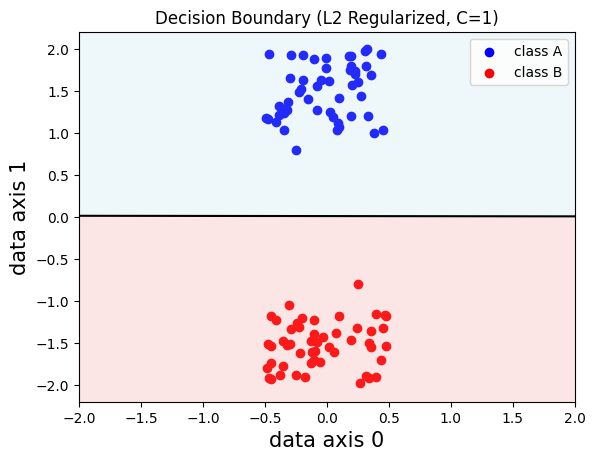

In [ ]:
data, labels = generate_block_data(50)
data = rotate_block_data(data, 0)

noisy_point_1, new_label_1 = torch.tensor([-0.25, 0.8]).unsqueeze(0), torch.tensor([1])
noisy_point_2, new_label_2 = torch.tensor([0.25, -0.8]).unsqueeze(0), torch.tensor([-1])

data = torch.cat([data, noisy_point_1, noisy_point_2], dim=0)
labels = torch.cat([labels, new_label_1, new_label_2], dim=0)

svm_results, svm_state_dicts = train_svm(data, labels, n_splits=5, test_size=0.2, train_epochs=1000, lr=0.01, reg_lambda=1)

svm_model = BinaryLinearSVM(data.shape[1])
svm_model.load_state_dict(svm_state_dicts[-1])

plot_hyperplane(data, labels, svm_model, 'Decision Boundary (L2 Regularized, C=1)')

Wow, that's a pretty different line! As we can see, with L2 regularization the fitted decision boundary is now much less sensitive to the noise points that we added.

So far we've been using a fixed reg_lambda value of 1. Let's now see how varying reg_lambda affects the decision boundary.

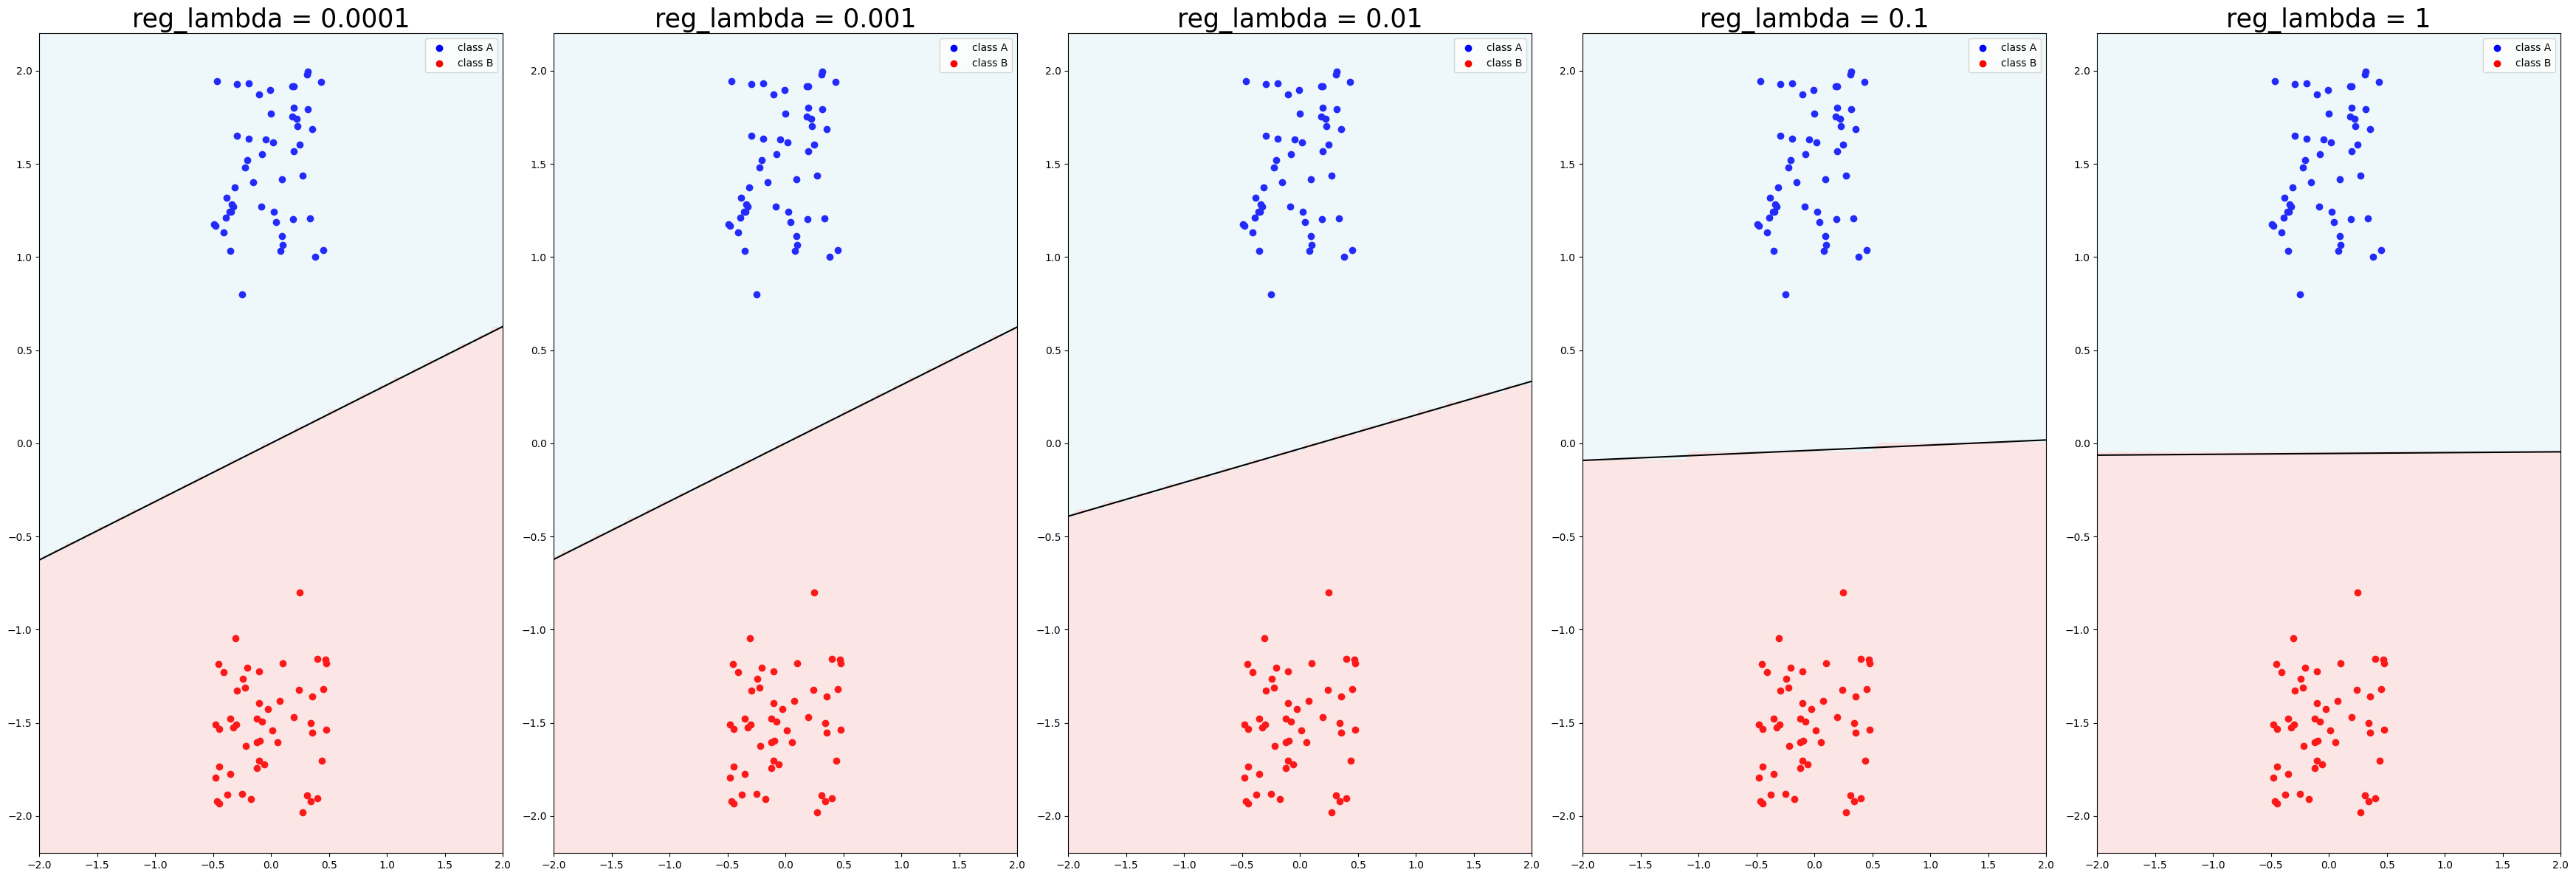

In [ ]:
def plot_hyperplanes(data, labels, models, titles):
    fig, axes = plt.subplots(1, len(models), figsize=(7*len(models), 12))

    if len(models) == 1:
        axes = [axes]

    for i, (model, title, ax) in enumerate(zip(models, titles, axes)):
        plt.sca(ax)

        dp = data[labels == 1]
        dm = data[labels == -1]
        plt.scatter(dp[:, 0], dp[:, -1], color='blue', label='class A')
        plt.scatter(dm[:, 0], dm[:, -1], color='red', label='class B')
        plt.legend()
        plt.xlim(-2, 2)
        plt.ylim(-2.2, 2.2)

        w0 = model.linear.weight[0, 0].item()
        w1 = model.linear.weight[0, 1].item()
        intr = model.linear.bias[0].item()
        m = -w0 / w1
        b = -intr / w1
        line = lambda x: m*x + b

        # Create a mesh grid for coloring the background
        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

        # Determine which side of the hyperplane each point is on
        Z = (xx * w0 + yy * w1 + intr) > 0

        # Color the background based on the decision boundary
        plt.contourf(xx, yy, Z, alpha=0.2, colors=['lightcoral', 'lightblue'])

        # Plot the decision boundary
        line0 = line(-2)
        line1 = line(2)
        plt.plot([-2, 2], [line0, line1], color='k')
        plt.title(title)

    for ax in axes:
        ax.set_title(ax.get_title(), fontsize=25)

    plt.tight_layout()

reg_lambdavalues = [0.0001, 0.001, 0.01, 0.1, 1]
l2_models = []
for reg_lambda in reg_lambdavalues:

    svm_results, svm_state_dicts = train_svm(data, labels, n_splits=1, test_size=0.1, train_epochs=1000, lr=0.01, reg_lambda=reg_lambda)

    svm_model = BinaryLinearSVM(data.shape[1])
    svm_model.load_state_dict(svm_state_dicts[-1])
    l2_models.append(copy.deepcopy(svm_model))

plot_hyperplanes(data, labels, l2_models, [f"reg_lambda = {reg_lambda}" for reg_lambda in reg_lambdavalues])

Notice how as we increase C, the decision boundary becomes less and less sensitive to the noise. In other words, as we increase regularization, our model becomes less sensitive to noise.


#### L1 Regularization

Now let's implement L1 regularization. L1 regularization follows the same general form as L2 regularization, but instead of penalizing the square of the weights, it penalizes the absolute value of the weights:

$L_{reg} = λ * Σ(|w_i|)$

Complete the function below to compute the L1 regularization term!


In [ ]:
def l1_regularization_term(model):

    # ---- YOUR CODE HERE ----
    # Hint: you can access model weights with model.linear.weight,
    # and you can compute the absolute value of the weights with torch.abs()
    reg_loss = torch.sum(torch.abs(model.linear.weight))
    # ----------------------

    return reg_loss

Now we can run the same comparison between reg_lambda values as before, but with L1 regularization instead. Note how we're now running the train_svm function with reg_type="L1".

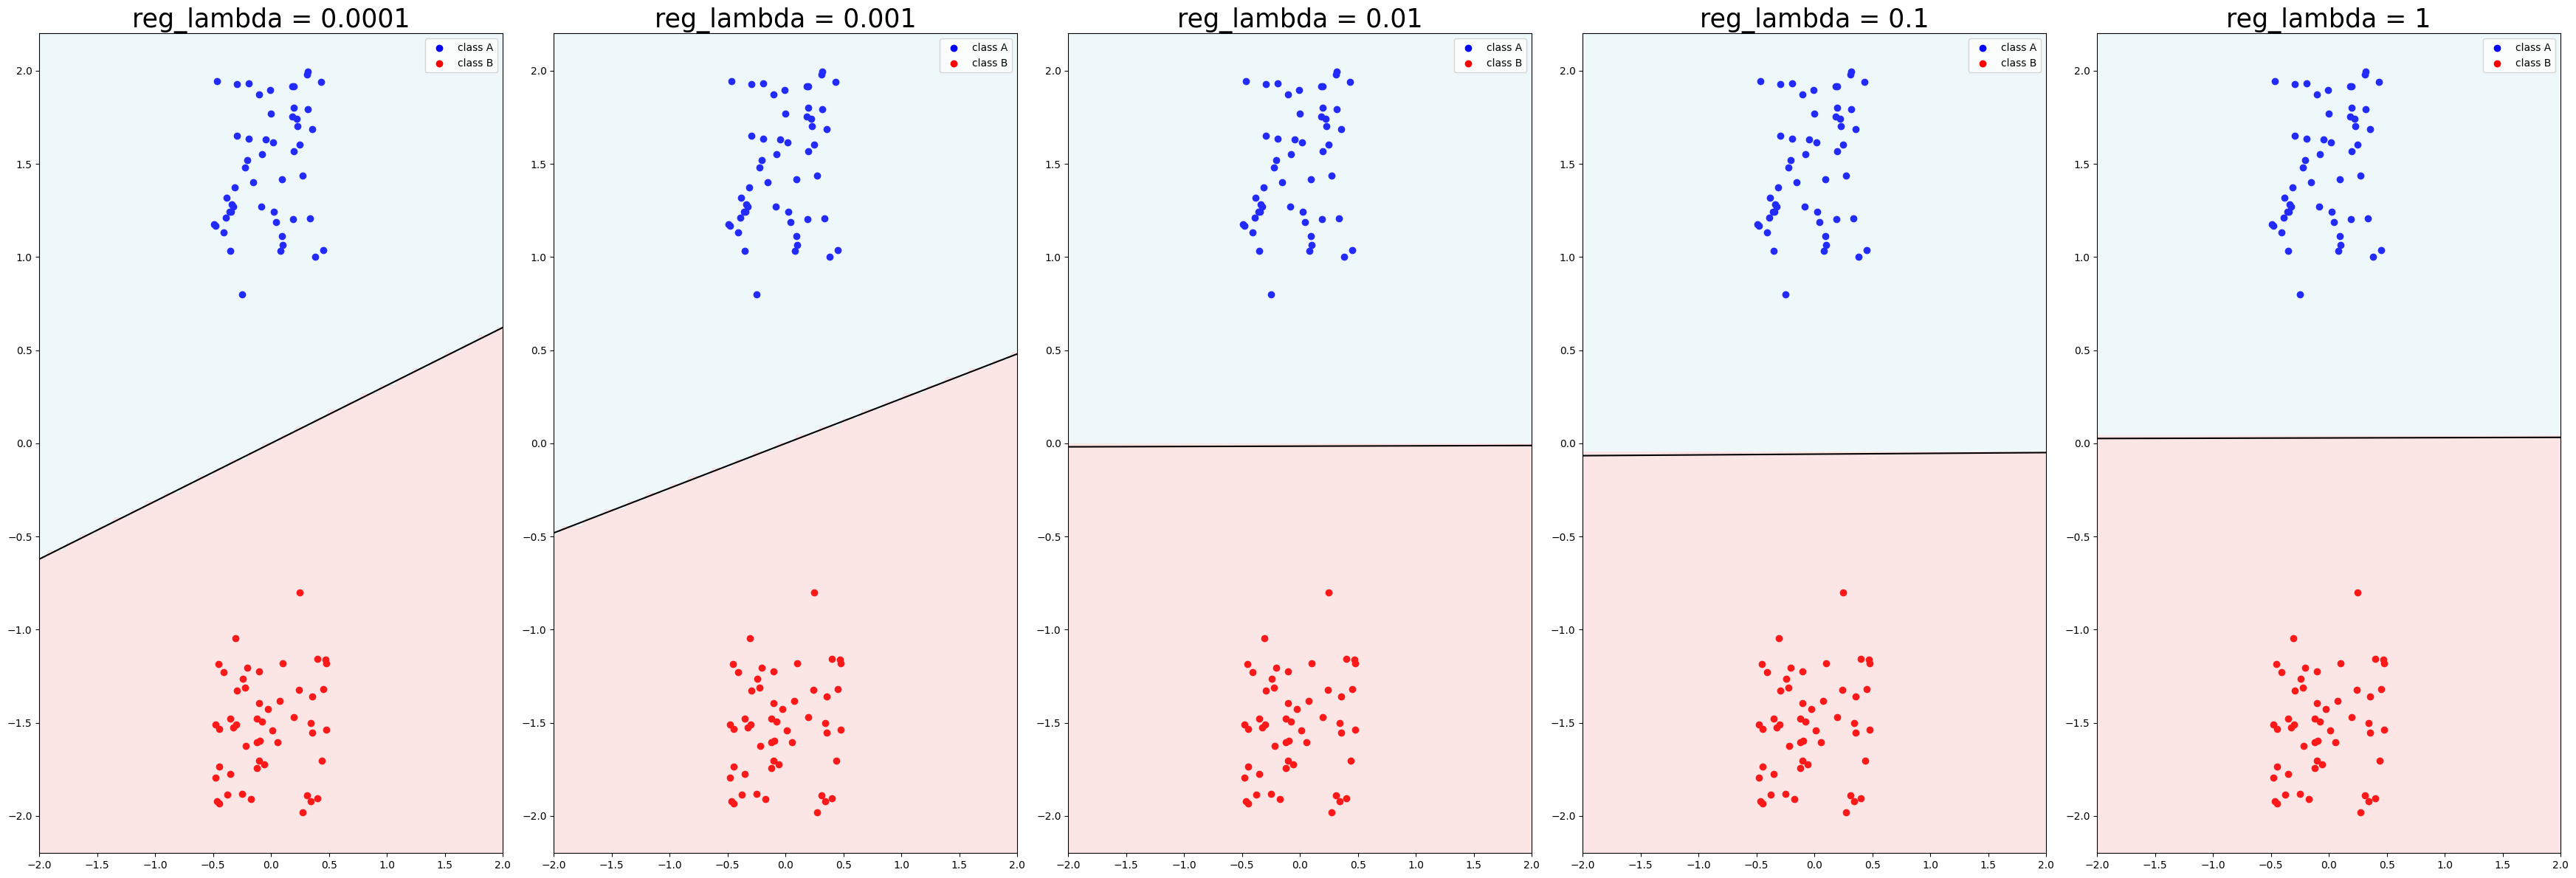

In [ ]:
reg_lambdavalues = [0.0001, 0.001, 0.01, 0.1, 1]
l1_models = []
for reg_lambda in reg_lambdavalues:

    svm_results, svm_state_dicts = train_svm(data, labels, n_splits=1, test_size=0.2, train_epochs=1000, lr=0.01, reg_lambda=reg_lambda, reg_type="L1")
    svm_model = BinaryLinearSVM(data.shape[1])
    svm_model.load_state_dict(svm_state_dicts[-1])
    l1_models.append(copy.deepcopy(svm_model))

plot_hyperplanes(data, labels, l1_models, [f"reg_lambda = {reg_lambda}" for reg_lambda in reg_lambdavalues])

## Regularization on real data

Now that we've implemented L1 and L2 regularization, let's graduate to some real data. Specifically, we're going to use the same IT cortex data as in the previous notebook.

Previously we learned to fit classifiers to this data, and this time we're going to fit regularized classifiers. Fitting regularized classifiers on this set of real data rather than our synthetic toy data will allow us to explore two subtlies of regularization: first, how regularization can help us fit models that generalize better to test data, and second, how L1 and L2 regularization differ.


In [ ]:
# Load the neural data
LECTURE_DIRECTORY = "/content/drive/MyDrive/psych254a_2025/data"

# Load the neural data
neural_data_file = os.path.join(LECTURE_DIRECTORY, "ventral_neural_data.hdf5")
ventral_dataset = h5py.File(neural_data_file, "r")

neural_data = torch.tensor(ventral_dataset['time_averaged_trial_averaged'][:])
meta_data = pd.DataFrame({
    key: [s.decode('utf-8') if isinstance(s, bytes) else s
          for s in ventral_dataset['image_meta'][key][:]]
    for key in ventral_dataset['image_meta'].keys()
})

First let's evaluate the performance of the SVM classifier on a boats vs cars task without regularization. To turn off regularization, we can set reg_lambda to 0. Let's complete the function below to evaluate SVM classifier performance for different values of reg_lambda.

In [ ]:
def evaluate_svm_classifier(reg_lambda, reg_type, cat1, cat2, vl, n_splits=5, test_size=0.2, train_epochs=1000, lr=0.01):

    # Prepare data
    mdata = meta_data[(meta_data["variation_level"] == vl) & (meta_data["category"].isin([cat1, cat2]))]
    ndata = neural_data[mdata.index] # These are our input features
    labels = mdata["category"].reset_index(drop=True)
    label_mapping = {cat1: 1, cat2: -1}
    labels = torch.tensor(labels.map(label_mapping)) # These are our labels

    # ---- YOUR CODE HERE ----
    # Initialize the SVM model
    input_dim = ndata.shape[1]
    svm_model = BinaryLinearSVM(input_dim)

    # Create cross-validation splitter
    cv_splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=SEED)

    # Create UniversalProcedure with hinge loss
    hinge_loss = HingeLoss()
    procedure = UniversalProcedure(cross_validator=cv_splitter, loss_func=hinge_loss, evaluation_metrics={"accuracy": classification_accuracy})

    # Train and evaluate
    svm_results, svm_state_dicts = procedure.evaluate(
        model=svm_model, x=ndata, y=labels, train_epochs=train_epochs, lr=lr, reg_type=reg_type, reg_lambda=reg_lambda
    )
    # ----------------------

    print('SVM Classifier Regularization reg_lambda = %s Var level %s train performance on %s vs %s: %.2f%%' % (
        reg_lambda,
        vl,
        cat1,
        cat2,
        100*svm_results['accuracy_train_mean'])
    )
    print('SVM Classifier Regularization reg_lambda = %s Var level %s test performance on %s vs %s: %.2f%%' % (
        reg_lambda,
        vl,
        cat1,
        cat2,
        100*svm_results['accuracy_test_mean'])
    )
    print()


for vl in ['V0', 'V3', 'V6']:
    evaluate_svm_classifier(reg_lambda=0, reg_type="L2", cat1="Boats", cat2="Cars", vl=vl)

SVM Classifier Regularization reg_lambda = 0 Var level V0 train performance on Boats vs Cars: 100.00%
SVM Classifier Regularization reg_lambda = 0 Var level V0 test performance on Boats vs Cars: 98.75%

SVM Classifier Regularization reg_lambda = 0 Var level V3 train performance on Boats vs Cars: 100.00%
SVM Classifier Regularization reg_lambda = 0 Var level V3 test performance on Boats vs Cars: 94.38%

SVM Classifier Regularization reg_lambda = 0 Var level V6 train performance on Boats vs Cars: 100.00%
SVM Classifier Regularization reg_lambda = 0 Var level V6 test performance on Boats vs Cars: 82.97%



Now let's see what happens when we add just a bit of L2 regularization, with reg_lambda=0.01

In [ ]:
for vl in ['V0', 'V3', 'V6']:
    evaluate_svm_classifier(reg_lambda=0.01, reg_type="L2", cat1="Boats", cat2="Cars", vl=vl)

SVM Classifier Regularization reg_lambda = 0.01 Var level V0 train performance on Boats vs Cars: 100.00%
SVM Classifier Regularization reg_lambda = 0.01 Var level V0 test performance on Boats vs Cars: 100.00%

SVM Classifier Regularization reg_lambda = 0.01 Var level V3 train performance on Boats vs Cars: 99.77%
SVM Classifier Regularization reg_lambda = 0.01 Var level V3 test performance on Boats vs Cars: 96.56%

SVM Classifier Regularization reg_lambda = 0.01 Var level V6 train performance on Boats vs Cars: 95.20%
SVM Classifier Regularization reg_lambda = 0.01 Var level V6 test performance on Boats vs Cars: 86.56%



Notice how when we add regularization, train performance *decreases* relative to no regularization, while test performance *increases* relative to no regularization. In other words, regularization is helping to prevent overfitting, and is thus helping the model generalize better to test data.

We can visualize this more clearly by plotting the mean and standard deviation of training and test accuracy as we vary reg_lambda:

Note how we can use this to pick an optimal level of regularization for our model -- in this case, reg_lambda=0.01 or 0.1 seem to be a good choices for classification at the V6 level, since that is the choice that maximizes test accuracy.

100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


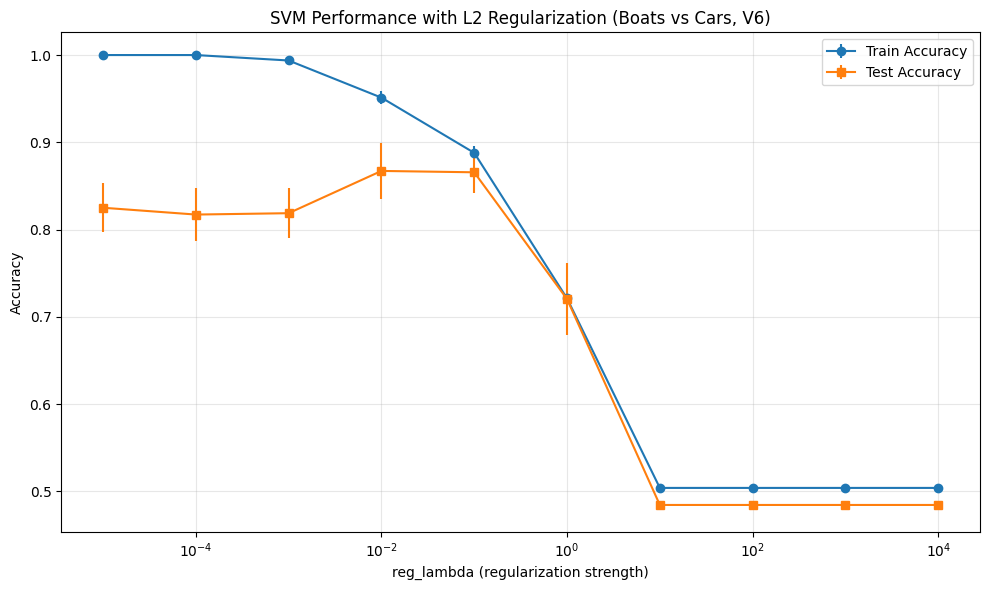

In [ ]:
reg_lambdavalues = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

def fit_svm_classifiers(cat1, cat2, vl, reg_type, reg_lambdavalues):
    rows = []
    for reg_lambda in tqdm(reg_lambdavalues):
        mdata = meta_data[(meta_data["variation_level"] == vl) & (meta_data["category"].isin([cat1, cat2]))]
        ndata = neural_data[mdata.index]
        labels = mdata["category"].reset_index(drop=True)
        label_mapping = {cat1: 1, cat2: -1}
        labels = torch.tensor(labels.map(label_mapping))

        svm_results, svm_state_dicts = train_svm(ndata, labels, n_splits=5, test_size=0.2, train_epochs=400, lr=0.01, reg_lambda=reg_lambda, reg_type=reg_type)

        weights = []
        for state_dict in svm_state_dicts:
            weight_tensor = state_dict['linear.weight']
            weight_values = weight_tensor.numpy().flatten()
            weights.extend(weight_values)

        rows.append({
            "reg_type": reg_type,
            "reg_lambda": reg_lambda,
            "mean_train_acc": svm_results['accuracy_train_mean'],
            "mean_test_acc": svm_results['accuracy_test_mean'],
            "std_train_acc": svm_results['accuracy_train_std'],
            "std_test_acc": svm_results['accuracy_test_std'],
            "weights": weights
        })
    df = pd.DataFrame(rows)
    return df


reg_type = "L2"
cat1 = "Boats"
cat2 = "Cars"
vl = "V6"
df = fit_svm_classifiers(cat1, cat2, vl, reg_type, reg_lambdavalues)
plt.figure(figsize=(10, 6))
plt.errorbar(df['reg_lambda'], df['mean_train_acc'], yerr=df['std_train_acc'], marker='o', label='Train Accuracy')
plt.errorbar(df['reg_lambda'], df['mean_test_acc'], yerr=df['std_test_acc'], marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('reg_lambda (regularization strength)')
plt.ylabel('Accuracy')
plt.title(f'SVM Performance with {reg_type} Regularization ({cat1} vs {cat2}, {vl})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


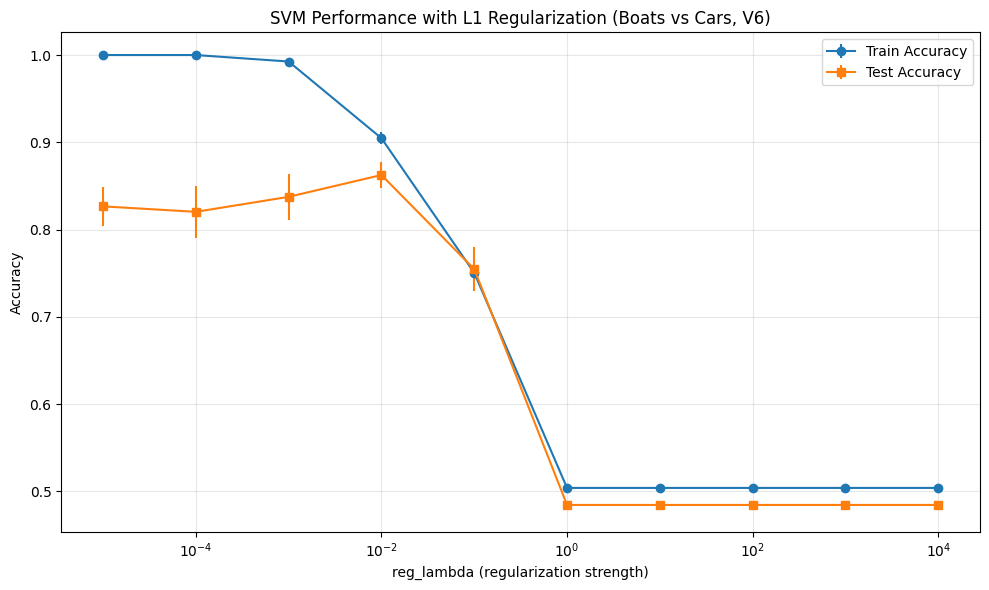

In [ ]:
reg_type = "L1"
cat1 = "Boats"
cat2 = "Cars"
vl = "V6"
df = fit_svm_classifiers(cat1, cat2, vl, reg_type, reg_lambdavalues)
plt.figure(figsize=(10, 6))
plt.errorbar(df['reg_lambda'], df['mean_train_acc'], yerr=df['std_train_acc'], marker='o', label='Train Accuracy')
plt.errorbar(df['reg_lambda'], df['mean_test_acc'], yerr=df['std_test_acc'], marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('reg_lambda (regularization strength)')
plt.ylabel('Accuracy')
plt.title(f'SVM Performance with {reg_type} Regularization ({cat1} vs {cat2}, {vl})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

The same applies to L1 regularization as well!

#### Comparing L1 and L2 Regularization

Finally, you might be asking: how are L1 and L2 regularization different? The results you've seen so far don't demonstrate particularly meaningful differences.

One important way that L1 and L2 regularization are different is that L1 regularization tends to produce sparse solutions, while L2 regularization tends to produce dense solutions.

To see this, let's compare the weights of models that are fit with L1 and L2 regularization.


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


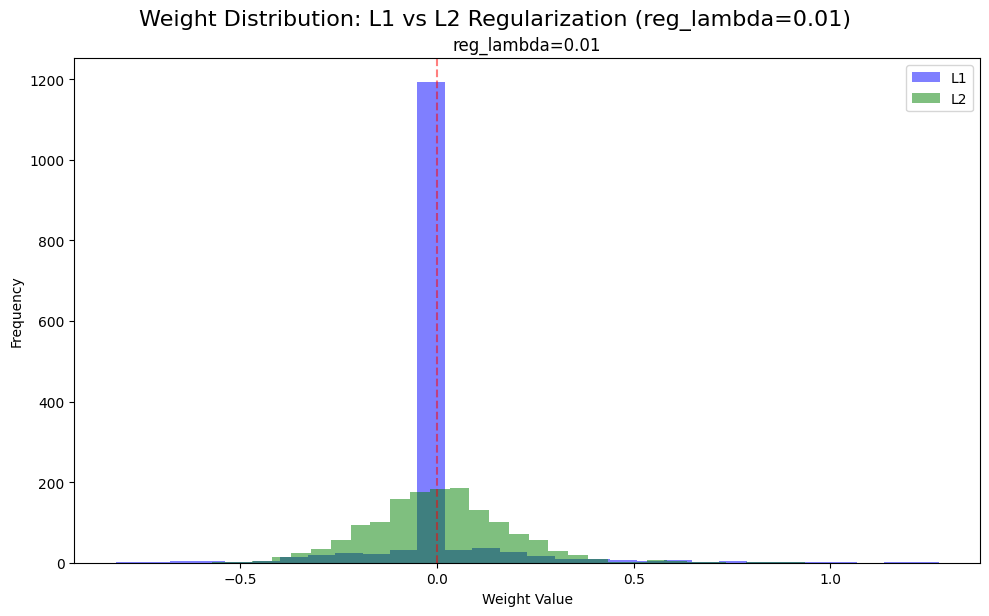

In [ ]:
l1_df = fit_svm_classifiers("Boats", "Cars", "V6", "L1", reg_lambdavalues)
l2_df = fit_svm_classifiers("Boats", "Cars", "V6", "L2", reg_lambdavalues)
df = pd.concat([l1_df, l2_df])
reg_lambda = 0.01


plt.figure(figsize=(10, 6))
for reg, color, alpha in [("L1", "blue", 0.5), ("L2", "green", 0.5)]:
    # Filter dataframe for this regularization type
    reg_df = df[df["reg_type"] == reg]

    # Get weights for this reg_lambda value
    weights = reg_df[reg_df["reg_lambda"] == reg_lambda].iloc[0]["weights"]

    # Plot histogram of weights
    plt.hist(weights, bins=30, alpha=alpha, color=color, label=reg)

# Add vertical line at 0
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.title(f"reg_lambda={reg_lambda}")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.suptitle("Weight Distribution: L1 vs L2 Regularization (reg_lambda=0.01)", y=1.02, fontsize=16)
plt.show()


As we can see, in the case of reg_lambda=0.01, a very large number of weights are roughly zero for L1 but not L2. This means that the L1 regularized solution is *sparser* than the L2 regularized solution.

Why? This is because L1 regularization penalizes the absolute value of the weights, while L2 regularization penalizes the square of the weights. As a result, the pressure to minimize a weight to zero is constant for L1 but weakens as the weight approaches zero for L2. Thus, L1 regularization is more likely to push weights to zero than L2 regularization.